In [2]:
import numpy as np

In [3]:
from tqdm import tqdm

In [4]:
def relu(x):
    return np.where(x >= 0, 
                        x, 
                        0)

In [5]:
def get_activation(activation):#maybe getderivatives here iteself ?
    def sigmoid(x):
        return np.where(x >= 0, 
                        1 / (1 + np.exp(-x)), 
                        np.exp(x) / (1 + np.exp(x)))
    def softmax(x):
        z=x-np.max(x,axis=0)
        return np.exp(z)/np.sum(np.exp(z),axis=0)
    def relu(x):
        rel=np.where(x >= 0, 
                            x, 
                            0)
        return rel
    if activation=='sigmoid':
        return sigmoid
    elif activation=='softmax':
        return softmax
    elif activation== 'tanh':
        return np.tanh
    elif activation== 'relu':
        return relu

In [6]:
def get_activation_derivative(activation):#maybe getderivatives here iteself ?
    def sigmoid_d(x):
        sig= np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
        return sig*(1-sig)
    def softmax_d(x):
        z=x-np.max(x,axis=0)
        soft=np.exp(z)/np.sum(np.exp(z),axis=0)
        return soft*(1-soft)
    def tanh_d(x):
        return 1-np.tanh(x)**2
    def relu_d(x):
        return np.where(x >= 0, 
                            x, 
                            0)
    
    if activation=='sigmoid':
        return sigmoid_d
    elif activation=='softmax':
        '''
        need to think more, not required for backprop as we look directly at dL/da_l
        But still, for the sake of completeness, and if user wants softmax in the middle?
        d S(x_i) /d x_j= S(x_i)*(kronecker delta_i,j -S(x_j))
        But we care about only dh_k,j/da_k,j So no need to implement d S(x_i) /d x_j
        d S(x_i) /d x_i should suffice
        so we get array of [ d S(x_1) /d x_1, d S(x_2) /d x_2, ....]
        
        For MSE loss after softmax, we need cross terms...
        '''
        
        return softmax_d
    elif activation=='tanh':
        return tanh_d
    elif activation=='relu':
        return relu_d
    assert(activation=='relu'or activation=='tanh'or activation=='sigmoid' or activation=='softmax'), 'Must be \'relu\'or \'tanh\' or \'sigmoid\' or \'softmax\' '


In [7]:
def get_loss(loss='cross-entropy'):
    
   
    
        
    def crossentropy(P,Q):
        assert(P.shape==Q.shape), "Inputs must be of same shape"

        return np.sum([-np.dot(P[:,i],np.log2(Q[:,i])) for i in range(P.shape[1])])
    def SE(P,Q):
        assert(P.shape==Q.shape), "Inputs must be of same shape"

        return np.sum(np.square(P-Q))
    
    if loss=="SE":
        return SE
    return crossentropy
    
    
      
    
    
    
    

In [8]:
def get_loss_derivative(loss):
    def SE_d(y_in,y_pred_in):
        '''
        derivative of MSE after softmax is used to get probabs from a_L:
        We need indicator because the all terms of y_true are required unlike cross-entropy where only y_pred[l] is required
        Thus transforming the stacked indicator to y_true, not here...
        
        '''

        def indicator(i,j):
                if i==j:
                    return 1
                return 0


        assert(y_in.shape[0]==y_pred_in.shape[0]),"Inputs must contain same number of examples"

        y=y_in.ravel()
        y_pred=y_pred_in.ravel()


        return np.array([
            [2*np.sum([(y_pred[i]-y[i])*y[i]*(indicator(i,j) - y_pred[j]) for i in range(y.shape[0])])]
            for j in range(len(y))
        ])    
   
    
        
    def crossentropy_d(y,y_pred):
        

        return -(y-y_pred)
    
    
    if loss=="cross-entropy":
        return crossentropy_d
    return SE_d
    

In [184]:
class layer:
    def __init__(self,input_size,output_size,activation='sigmoid',type_='random'):
            
        ''' 
        output size number of neurons i
        input size j
        
        '''
        assert(type_=='random'or type_=='xavier'or type=='glorot' or type=='He' ), 'Must be \'random\'or \'xavier\' or \'glorot\' or \'He\' '
        
        if type_=='random':
            scale=0.01
            self.W=np.random.randn(output_size,input_size)*scale #size ixj
            self.b=np.zeros((output_size,1))         #size i
            
        elif type_=='xavier' or type_=='glorot':
            # Xavier Uniform
            r=np.sqrt(6/(input_size+output_size))
            self.W=np.random.uniform(-r,r,(output_size,input_size))
            self.b=np.zeros((output_size,1))
            
        else:#He
            self.W= np.random.randn(output_size,input_size)*np.sqrt(2/input_size)
            self.b=np.zeros((output_size,1))
            
                
            
            
            
        self.a=np.zeros((output_size,1))          #size i
        self.h=np.zeros((output_size,1))         #size i
        self.g=get_activation(activation)
        
        self.d_a=np.zeros((output_size,1))
        self.d_h=np.zeros((output_size,1))
        self.d_W=np.zeros((output_size,input_size))
        self.d_b=np.zeros((output_size,1))
        self.d_g=get_activation_derivative(activation)
        
        
        
    def forward(self, inputs):
        self.a=self.b+np.matmul(self.W,inputs)
        self.h=self.g(self.a)
        return self.h
    def reset(self):
        self.d_a=np.zeros(np.shape(self.d_a))
        self.d_h=np.zeros(np.shape(self.d_h))
        self.d_W=np.zeros(np.shape(self.d_W))
        self.d_b=np.zeros(np.shape(self.d_b))
        
    def hard_set(self,W,b):#hardsets the weight. useful for debugging
        self.W=W
        self.b=b
        


In [78]:
class Model:
    def __init__(self,X_size,Y_size,hidden_layer_sizes=[4],hidden_layer_activations=['sigmoid'],loss='cross-entropy',lamdba_m=0):
        '''
        '''   
        
        self.input_size=X_size
        self.output_size=Y_size
        self.hidden_layer_sizes=hidden_layer_sizes
        self.layers=[]
        
        prev_size=self.input_size
    
        for size,activation in zip(hidden_layer_sizes,hidden_layer_activations):
            self.layers.append(layer(prev_size,size,activation))
            prev_size=size
        self.layers.append(layer(size,self.output_size,'softmax'))
        
        self.loss=get_loss(loss)#without regularization term
        self.loss_d=get_loss_derivative(loss)
        self.lamdba_m=lamdba_m #we shall pass lambda/m to this, where m is patch size
        
    def forward(self,x):
        output=x
        # print(output.shape)
        for layer in  self.layers:
            # print('W',layer.W.shape)
            output=layer.forward(output)
            # print(output.shape)   
        return output
    
    def reset(self):
        for layer in  self.layers:
            # resets the dWs
            layer.reset()
    
 
        
    
          
            
    def backward(self,x,y,y_pred):
        # self.layers[-1].d_h is not needed as d_h is used to calculate d_a and self.layers[-1].h is softmax
        self.layers[-1].d_a=self.loss_d(y,y_pred)
            
        
        
        for idx in range(len(self.layers)-1,0,-1): #goes from L->2, for l=1 we do outside
            
            
            #compute gradient wrt parameters
            self.layers[idx].d_W+=np.matmul(self.layers[idx].d_a,np.transpose(self.layers[idx-1].h))+self.lamdba_m*self.layers[idx].W
            self.layers[idx].d_b+=self.layers[idx].d_a
            
            #compute gradient wrt layer below -- will help in next layer iter
            self.layers[idx-1].d_h=np.matmul(np.transpose(self.layers[idx].W),self.layers[idx].d_a)
            
            #compute gradient -- element wise multiplivation, derivative of the activation function of layer idx-1
            self.layers[idx-1].d_a=self.layers[idx-1].d_h*self.layers[idx-1].d_g(self.layers[idx-1].a)
        assert(idx-1==0)
                        
        self.layers[0].d_W+=np.matmul(self.layers[0].d_a,np.transpose(x))+self.lamdba_m*self.layers[0].W
        self.layers[0].d_b+=self.layers[0].d_a
        
        
        
    def predict(self,Xtest):
        preds=[]
        for i in range(Xtest.shape[1]):
            preds.append(self.forward(Xtest[:,[i]]))
        
        ytest_pred=np.hstack(preds)
        return ytest_pred
    
        
        
                    
                
                
            
            
            
        
    
            
            
        
            
            

In [11]:
class optimizers:
    def __init__(self,X_size,Y_size,hidden_layer_sizes=[4],hidden_layer_activations=['sigmoid'],
                 loss='cross-entropy',optimizer='adam',lamdba=0,batch_size=5,epochs=10,eta=1e-3):
        self.batch_size=batch_size
        self.epochs=epochs
        self.train_loss=[]
        self.val_loss=[]
        self.model=Model(X_size,Y_size,hidden_layer_sizes,hidden_layer_activations,loss,lamdba/self.batch_size)
        self.learning_rate=eta/batch_size
        self.optimizer=optimizer

        

    def batch_gradient_descent(self,traindat,testdat,verbose=False):
        
        '''
        Mini-Batch Gradient Descent
        at batchsize=1, behaves like sgd, batchsize=np.shape(X), behaves as gd
        eta is the learning rate
        '''
        X,Y=traindat
        
        Xval,Yval=testdat
        
        

        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                
                #update if the number of points seen==batch size, or if data ends
                if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                    for layer in self.model.layers:
                        layer.W=layer.W-self.learning_rate*layer.d_W
                        layer.b=layer.b-self.learning_rate*layer.d_b
                    self.model.reset() #reset grads before new epoch
            
            #end of epoch
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
            
    def stochastic_gradient_descent(self,traindat,testdat,eta=1e-3,max_iters=10):
        
        
        '''
        stochastic Gradient Descent
        '''
                
        X,Y=traindat
        
        Xval,Yval=testdat

        for t in tqdm(range(self.epochs)):
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                
                #update
                for layer in self.model.layers:
                    layer.W=layer.W-self.learning_rate*layer.d_W
                    layer.b=layer.b-self.learning_rate*layer.d_b
                self.model.reset() #reset grads before new update
                    
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
        
    def Momentum(self,traindat,testdat,beta=0.9):
        ''''''
        
        X,Y=traindat
        
        Xval,Yval=testdat
        u_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        u_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]

        



        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                



            #update if the number of points seen==batch size, or if data ends
            if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                for i in range(len(self.model.layers)):
                    layer=self.model.layers[i]
                    u_W[i]=beta*u_W[i]+layer.d_W
                    u_b[i]=beta*u_b[i]+layer.d_b
                    layer.W=layer.W-self.learning_rate*u_W[i]
                    layer.b=layer.b-self.learning_rate*u_b[i]
                self.model.reset() #reset grads before new update
                
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
                


    def rmsprop(self,traindat,testdat,beta=0.9):
        ''''''
        X,Y=traindat
        
        Xval,Yval=testdat
        
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        t=0
        epsilon=1e-10



        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                


    

            #update if the number of points seen==batch size, or if data ends
            if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                for i in range(len(self.model.layers)):
                    layer=self.model.layers[i]
                    v_W[i]=beta*v_W[i]+(1-beta)*layer.d_W**2
                    v_b[i]=beta*v_b[i]+(1-beta)*layer.d_b**2
                    layer.W=layer.W-(self.learning_rate/np.sqrt(v_W[i]+epsilon))*layer.d_W
                    layer.b=layer.b-(self.learning_rate/np.sqrt(v_b[i]+epsilon))*layer.d_b
                self.model.reset() #reset grads before new epoch
                
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])

            
    def Adam(self,traindat,testdat,beta1=0.9, beta2=0.999):
        ''''''
        X,Y=traindat
        
        Xval,Yval=testdat
        
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        
        epsilon=1e-10



        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                


    

            #update if the number of points seen==batch size, or if data ends
            if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                for i in range(len(self.model.layers)):
                    layer=self.model.layers[i]
                    #updating momentum, velocity
                    m_W[i]=beta1*m_W[i]+(1-beta1)*layer.d_W
                    m_b[i]=beta1*m_b[i]+(1-beta1)*layer.d_b
                    
                    v_W[i]=beta2*v_W[i]+(1-beta2)*layer.d_W**2
                    v_b[i]=beta2*v_b[i]+(1-beta2)*layer.d_b**2
                    
                    m_W_hat=m_W[i]/(1-np.power(beta1,t+1))
                    m_b_hat=m_b[i]/(1-np.power(beta1,t+1))
                    v_W_hat=v_W[i]/(1-np.power(beta2,t+1))
                    v_b_hat=v_b[i]/(1-np.power(beta2,t+1))
                    
                    
                    
                    layer.W=layer.W-(self.learning_rate*m_W_hat)/(np.sqrt(v_W_hat)+epsilon)
                    layer.b=layer.b-(self.learning_rate*m_b_hat)/(np.sqrt(v_b_hat)+epsilon)
                self.model.reset() #reset grads before new epoch
                
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
    
    def NAG(self,traindat,testdat,beta=0.9):
        
        ''''''
        
        X,Y=traindat
        
        
        Xval,Yval=testdat
        
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        
        

        



        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                



            #update if the number of points seen==batch size, or if data ends
            if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                for i in range(len(self.model.layers)):
                    layer=self.model.layers[i]
                    m_W[i]=beta*m_W[i]+self.learning_rate*layer.d_W
                    m_b[i]=beta*m_b[i]+self.learning_rate*layer.d_b

                    
                    layer.W=layer.W-(beta*m_W[i]+self.learning_rate*layer.d_W[i])
                    layer.b=layer.b-(beta*m_b[i]+self.learning_rate*layer.d_b[i])
                self.model.reset() #reset grads before new epoch
                
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
    
    def NAdam(self,traindat,testdat,beta1=0.9, beta2=0.999):
        ''''''
        
        X,Y=traindat
        
        Xval,Yval=testdat
        
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        
        epsilon=1e-10



        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                


    

            #update if the number of points seen==batch size, or if data ends
            if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                for i in range(len(self.model.layers)):
                    layer=self.model.layers[i]
                    #updating momentum, velocity
                    m_W[i]=beta1*m_W[i]+(1-beta1)*layer.d_W
                    m_b[i]=beta1*m_b[i]+(1-beta1)*layer.d_b
                    
                    v_W[i]=beta2*v_W[i]+(1-beta2)*layer.d_W**2
                    v_b[i]=beta2*v_b[i]+(1-beta2)*layer.d_b**2
                    
                    m_W_hat=m_W[i]/(1-np.power(beta1,t+1))
                    m_b_hat=m_b[i]/(1-np.power(beta1,t+1))
                    v_W_hat=v_W[i]/(1-np.power(beta2,t+1))
                    v_b_hat=v_b[i]/(1-np.power(beta2,t+1))
                    
                    
                    
                    layer.W=layer.W-(self.learning_rate/(np.sqrt(v_W_hat)+epsilon))*\
                    (beta1*m_W_hat+((1-beta1)/(1-np.power(beta1,t+1)))*layer.d_W)
                    layer.b=layer.b-(self.learning_rate/(np.sqrt(v_b_hat)+epsilon))*\
                    (beta1*m_b_hat+((1-beta1)/(1-np.power(beta1,t+1)))*layer.d_b)
                    
                self.model.reset() #reset grads before new epoch
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])

                
        
            



        

        
    

In [12]:
class optimizers_tester:
    def __init__(self,X_size,Y_size,hidden_layer_sizes=[4],hidden_layer_activations=['sigmoid'],
                 loss='cross-entropy',optimizer='adam',lamdba=0,batch_size=5,epochs=10,eta=1e-3):
        self.batch_size=batch_size
        self.epochs=epochs
        self.train_loss=[]
        self.val_loss=[]
        self.model=Model(X_size,Y_size,hidden_layer_sizes,hidden_layer_activations,loss,lamdba/self.batch_size)
        self.learning_rate=eta
        self.optimizer=optimizer

        

    def batch_gradient_descent(self,traindat,testdat,verbose=False):
        
        '''
        Mini-Batch Gradient Descent
        at batchsize=1, behaves like sgd, batchsize=np.shape(X), behaves as gd
        eta is the learning rate
        '''
        X,Y=traindat
        
        Xval,Yval=testdat
        WTrack=[]
        bTrack=[]
        dWTrack=[]
        dbTrack=[]
        
#         !!!!!!
        

        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                
                #update if the number of points seen==batch size, or if data ends
                if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                    dWTrack_layer=[]
                    dbTrack_layer=[]
                    WTrack_layer=[]
                    bTrack_layer=[]
                    
                    for layer in self.model.layers:
                        layer.W=layer.W-self.learning_rate*layer.d_W
                        layer.b=layer.b-self.learning_rate*layer.d_b
                        
                        WTrack_layer.append(layer.W)
                        bTrack_layer.append(layer.b)
                        dWTrack_layer.append(layer.d_W)
                        dbTrack_layer.append(layer.d_b)
                    dWTrack.append(dWTrack_layer)    
                    dbTrack.append(dbTrack_layer)
                    WTrack.append(WTrack_layer)    
                    bTrack.append(bTrack_layer)  
                    self.model.reset() #reset grads before new epoch
            
            #end of epoch
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
            
        return dWTrack,dbTrack,WTrack,bTrack
            

In [13]:
ce=get_loss('')

In [14]:
ce

<function __main__.get_loss.<locals>.crossentropy(P, Q)>

# Import Dataset

In [215]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


# np.random.seed(42)#sets a seed, used for reproducability

def one_hot(inarray): #converts to one hot encoding
    outarray = np.zeros((inarray.size, inarray.max() + 1))
    outarray[np.arange(inarray.size), inarray] = 1
    return outarray

def Preprocess(X,y):
      
    '''Unrolls X,y, rehsapes into column vectors, one hots y'''
    assert(X.shape[0]==y.shape[0]),"Inputs must contain same number of examples, stored in rows" #checks if same dim
    
    X_processed=np.reshape(X,(X.shape[0],784))/255
    X_processed=X_processed.T
    y_processed=one_hot(y).T
    return np.array(X_processed),y_processed
        
    



Xtest,ytest=Preprocess(X_test,y_test)

# def tran_val_split(X,y,split=0.1):
#     assert(X.shape[1]==y.shape[1]), "Inputs must contain same number of examples, stored in columns"# as vectors are now stored in cols, do check if no of elemnts are equal
#     len_split=int(np.shape(X)[1]*split)
#     X_val=X[:,:len_split]
#     y_val=y[:,:len_split]
    
#     X_train=X[:,len_split:]
#     y_train=y[:,len_split:]
    
#     return (X_train,y_train),(X_val,y_val)
    
        

# (Xtrain,ytrain),(Xval,yval)=tran_val_split(X_train_clean,y_train_clean)
from sklearn.model_selection import train_test_split

Xtrain,Xval,ytrain,yval=train_test_split(X_train,y_train,test_size=0.1)
Xtrain,ytrain=Preprocess(Xtrain,ytrain)
Xval,yval=Preprocess(Xval,yval)

In [216]:
Xx,Yy=Preprocess(X_train[:16],y_train[:16])

In [208]:
Yy

array([[0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])

In [16]:
get_activation('relu')

<function __main__.get_activation.<locals>.relu(x)>

In [17]:
import matplotlib.pyplot as plt

In [18]:
def accuracy_check(Y,Ypred):
    return np.sum(np.argmax(Ypred,axis=0)==np.argmax(Y,axis=0))/Y.shape[1]
    
    
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.96s/it]


3.32212228986385 3.322690187734435
Accuracy train 0.10001851851851852
Accuracy val 0.09983333333333333


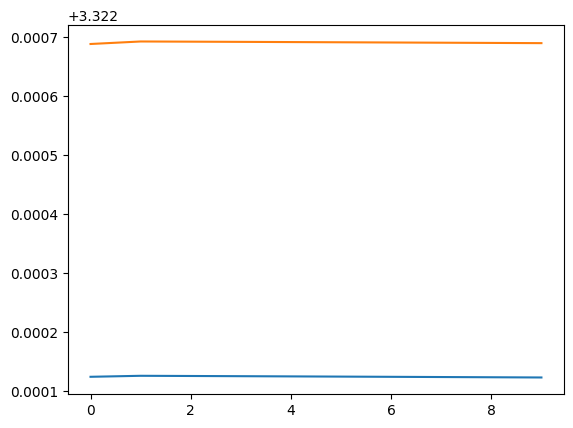

In [218]:
opt=optimizers_tester(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['relu','relu','relu'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=10,eta=1e-3)
DW,DB,WT,BT=opt.batch_gradient_descent((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)




print(opt.train_loss[-1],opt.val_loss[-1])

print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

In [219]:
for i in range(10):
    print([np.linalg.norm(DW[i][j]) for j in range(4)])

[6.280934698601293e-10, 3.3041923966243345e-09, 5.185318077833826e-07, 0.0029935050802200646]
[6.573538655111388e-10, 3.0503412525824823e-09, 5.87013923845458e-07, 0.003011426298152181]
[1.2397384666687934e-09, 4.695714209746269e-09, 5.894330591892827e-07, 0.0025692453442978944]
[3.1296205593576663e-09, 1.1126985728215802e-08, 1.2880297088488786e-06, 0.0038807842045859775]
[9.78472578364811e-10, 3.99349561083512e-09, 6.026448760050339e-07, 0.0033940864147862055]
[1.3714218437133645e-09, 4.92776693679231e-09, 5.904138839343579e-07, 0.0035477505040907354]
[5.960441394240755e-10, 2.560117885680901e-09, 4.415364181610684e-07, 0.002691973725071486]
[1.0156548273879912e-09, 5.857717008971847e-09, 7.566690476471565e-07, 0.004957725289799827]
[9.75833598593876e-10, 4.243284628651725e-09, 6.310929527441169e-07, 0.003564241970441968]
[8.966993031295988e-10, 3.147226461757269e-09, 5.660790662879645e-07, 0.0024335460012537505]


In [220]:
for i in range(10):
    print(DW[i][0])#layer x ke oopar

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -6.16935278e-15
  -6.62076883e-15 -1.95613625e-15]
 [ 0.00000000e+00 -9.20532748e-16 -8.53165089e-15 ...  1.72043430e-12
  -1.92222086e-13 -5.53791780e-14]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.82855896e-16  7.38516449e-16 ...  3.95004668e-12
   6.77007857e-13  2.01004382e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   5.15561574e-16 -2.44175052e-16]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.30252237e-18 ... -8.74487344e-15
  -5.98333446e-15  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.0000000

In [221]:
for i in range(10):
    print([np.linalg.norm(WT[i][j]) for j in range(4)])

[1.5855532923901907, 0.32801205322482196, 0.31321740938214887, 0.17772092253008126]
[1.5855532923902018, 0.32801205322499477, 0.31321740940649456, 0.17772100627736984]
[1.5855532923902138, 0.3280120532252221, 0.31321740943603216, 0.1777212002508608]
[1.5855532923902602, 0.32801205322581706, 0.3132174094769973, 0.17772142240996408]
[1.5855532923902687, 0.3280120532259992, 0.3132174094901253, 0.17772148375817715]
[1.5855532923902833, 0.32801205322623533, 0.31321740952021665, 0.1777217709109605]
[1.585553292390291, 0.32801205322629895, 0.3132174095092497, 0.17772160849976493]
[1.5855532923903026, 0.32801205322661503, 0.3132174095464804, 0.17772188386212814]
[1.5855532923903062, 0.3280120532267368, 0.3132174095587403, 0.1777220181742845]
[1.5855532923903144, 0.328012053226874, 0.3132174095683763, 0.17772200799882318]


In [222]:
for i in range(10):
    print(WT[i][0])#layer x ke oopar

[[ 2.55937835e-03 -1.31277167e-02 -4.99132059e-03 ... -1.09700703e-02
   5.25775632e-05  4.12954370e-03]
 [ 4.35701741e-04 -1.38486052e-02  2.06764415e-03 ... -6.19141847e-03
  -7.14447690e-03  8.02009888e-03]
 [-1.35990897e-02 -1.56033615e-02  1.04689854e-02 ... -1.61525652e-02
   6.15033489e-03  1.07782343e-02]
 ...
 [-1.49873835e-02  1.01310611e-02 -2.05770053e-03 ...  6.46410322e-03
   3.14579299e-04 -4.07933977e-02]
 [ 7.05870455e-03 -8.29762896e-03  9.34471214e-03 ... -1.12122699e-03
  -1.77955407e-03  2.01016185e-02]
 [-8.23999027e-03 -1.42632689e-02 -8.84242194e-03 ...  9.45867790e-03
  -6.00583075e-03 -1.28766155e-03]]
[[ 2.55937835e-03 -1.31277167e-02 -4.99132059e-03 ... -1.09700703e-02
   5.25775632e-05  4.12954370e-03]
 [ 4.35701741e-04 -1.38486052e-02  2.06764415e-03 ... -6.19141847e-03
  -7.14447690e-03  8.02009888e-03]
 [-1.35990897e-02 -1.56033615e-02  1.04689854e-02 ... -1.61525652e-02
   6.15033489e-03  1.07782343e-02]
 ...
 [-1.49873835e-02  1.01310611e-02 -2.0577005

In [ ]:
WT[1][0]

In [ ]:
opt=optimizers(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=10,eta=1e-5)
opt.Momentum((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)




print(opt.train_loss[-1],opt.val_loss[-1])

print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

In [ ]:
opt=optimizers(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=1,epochs=10,eta=1e-5)
opt.Momentum((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)




print(opt.train_loss[-1],opt.val_loss[-1])

print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

In [ ]:
opt=optimizers(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=10,eta=1e-5)
opt.Momentum((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)




print(opt.train_loss[-1],opt.val_loss[-1])

print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

In [ ]:
opt.train_loss[0]

In [ ]:
opt=optimizers(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=10,eta=1e-2)
opt.Adam((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)


print(opt.train_loss[-1],opt.val_loss[-1])
print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

In [ ]:
opt=optimizers(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=10,eta=1e-1)
opt.Adam((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)


print(opt.train_loss[-1],opt.val_loss[-1])
print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

In [ ]:
opt=optimizers(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=10,eta=1e-3)
opt.Adam((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)


print(opt.train_loss[-1],opt.val_loss[-1])
print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

In [ ]:
opt=optimizers(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=10,eta=1e-3)
opt.NAG((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)




print(opt.train_loss[-1],opt.val_loss[-1])

print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

In [ ]:
opt=optimizers(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=10,eta=1e-3)
opt.rmsprop((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)




print(opt.train_loss[-1],opt.val_loss[-1])

print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

In [ ]:
opt=optimizers(Xtrain.shape[0],ytrain.shape[0],[64,64,64],['tanh','tanh','tanh'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=64,epochs=20,eta=1e-3)
opt.NAdam((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)


print(opt.train_loss[-1],opt.val_loss[-1])
print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

In [ ]:
get_activation('relu')

In [ ]:
ytrain[:,[5]]

In [ ]:
opt1=optimizers_beta(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=10,eta=1)
opt1.Momentum(Xtrain,ytrain)

In [ ]:
opt1.model.predict(Xtrain)

In [ ]:
opt.val_loss

In [ ]:
opt.train_loss

In [ ]:
Xtrain.shape

In [ ]:
opt.model.predict(Xtrain[:,[1
                           ]])

In [ ]:
ytrain[:,[0]]

In [ ]:
opt=optimizers(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=1,epochs=10,eta=1e-3)
opt.Adam((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)




print(opt.train_loss[-1],opt.val_loss[-1])

print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

In [20]:
ytrain[:,[0]]

array([[1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

# Shapap

In [277]:
np.random.seed(0)

In [278]:
shapap=optimizers(Xtrain.shape[0],ytrain.shape[0],[5,5,5],['relu','relu','relu'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=16,epochs=10,eta=1e-1)

In [279]:
Ypred=shapap.model.forward(Xx)

In [280]:
shapap.model.layers[0].a

array([[-4.57497958e-01, -3.73838419e-01, -1.38506188e-01,
        -1.84785739e-01, -3.49965304e-01, -2.15167615e-01,
        -1.64455218e-01, -4.24412739e-01, -9.53258543e-02,
        -1.13612899e-01, -3.76787240e-01, -4.42210553e-01,
        -1.70793795e-01, -9.23270012e-02, -1.09692716e-01,
        -3.38804149e-01],
       [ 9.28711497e-02,  2.76653672e-02, -2.48451862e-02,
        -6.35902708e-04, -5.26088578e-02,  1.16236986e-01,
         1.03458197e-01,  6.67683267e-02, -1.22379863e-02,
         5.01254676e-02,  9.59240407e-02,  1.94725573e-01,
         5.26731299e-02, -2.18407140e-02,  5.78365041e-02,
         1.27124157e-01],
       [-2.30183122e-01, -1.67949529e-01, -9.24765413e-02,
        -1.24965639e-01, -1.30870415e-01, -1.83593745e-01,
        -1.99246114e-02, -1.77127657e-01,  4.76844844e-02,
         2.14324812e-03, -1.20095288e-01, -1.30267760e-01,
        -1.01596768e-01, -2.99721894e-02,  6.00506298e-02,
        -1.71606325e-01],
       [-1.37646553e-01, -7.86085075e

In [281]:
shapap.model.backward(Xx,Yy,shapap.model.forward(Xx))

ValueError: non-broadcastable output operand with shape (10,1) doesn't match the broadcast shape (10,16)

In [270]:
for i in range(Xx.shape[1]):
    shapap.model.backward(Xx[:,[i]],Yy[:,[i]],shapap.model.forward(Xx[:,[i]]))

In [272]:
shapap.model.layers[0].d_W

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.03196344e-17,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [265]:
shapap.model.layers[3].d_W

array([[ 0.00000000e+00,  0.00000000e+00,  2.67737280e-07,
         1.72480236e-07,  1.15345572e-06],
       [ 0.00000000e+00,  0.00000000e+00,  2.67737265e-07,
         1.72480226e-07,  7.22084530e-06],
       [ 0.00000000e+00,  0.00000000e+00,  2.67737256e-07,
         1.72480220e-07, -1.76345528e-06],
       [ 0.00000000e+00,  0.00000000e+00,  2.67737260e-07,
         1.72480223e-07,  7.22084414e-06],
       [ 0.00000000e+00,  0.00000000e+00,  2.67737264e-07,
         1.72480225e-07,  7.22084511e-06],
       [ 0.00000000e+00,  0.00000000e+00,  2.67737274e-07,
         1.72480232e-07,  5.85629429e-07],
       [ 0.00000000e+00,  0.00000000e+00,  2.67737274e-07,
         1.72480232e-07,  7.22084353e-06],
       [ 0.00000000e+00,  0.00000000e+00, -2.40963539e-06,
        -1.55232204e-06, -8.33651396e-06],
       [ 0.00000000e+00,  0.00000000e+00,  2.67737259e-07,
         1.72480222e-07,  7.22084401e-06],
       [ 0.00000000e+00,  0.00000000e+00,  2.67737258e-07,
         1.72480222e-07